In [1]:
"""
Created on Mon Mar 13 10:18:43 2023

@author: 
    Voon Hui Lai (voonhui.lai@anu.edu.au)
    Research School of Earth Sciences, Australian National University

Read and plot HDF5 files recorded by the SISSLE DAS array.

HDF5 file structure:
['DAS'] - 2D matrix of strain-rate measurement in nano-strain (time x channels)

#    Single file duration: 
        1 minute (depending on distance from earthquake) 
        
#    time sampling: 
        delta = 0.01 s ( 100 Hz) (decimated from 1000 Hz)
        start time of file == file name (do not confuse with time stamps in file headers which is referring to acquisition time)
        start time in UTC (and yes. the file starting second is 7 sec. I know how annoying it is)
        reason: the acquisition rebooted. and there wasn't enough bandwidth 
        to adjust the timestamp remotely without crashing the system
        
#    Amplitude unit:
        nanostrain-rate (converted from raw count)
        
#    channel:
        1 channel spacing = 4 m
        distance 0 m at interrogator. Negative distances refer to fibre bundles within interrogator.  
"""

import h5py
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.colorbar as cb
from matplotlib.ticker import (AutoMinorLocator, AutoLocator)
import mpl_toolkits.axes_grid1 as axes_grid1

In [2]:
# Define input HDF5 file

DAS_fileIN = '../../data/earthquakes/sissle/DAS_data_100Hz/us7000jkbd/south30_100Hz_UTC_20230316_005500.055.h5'
print('Input HDF5 file %s' %(DAS_fileIN) )

Input HDF5 file ../../data/earthquakes/sissle/DAS_data_100Hz/us7000jkbd/south30_100Hz_UTC_20230316_005500.055.h5


In [5]:
# Read input HDF5 file and populate important parameters

f_in = h5py.File(DAS_fileIN, 'r')
key = list(f_in.keys())
print('Keys within H5 file\n', key)

DAS_data = f_in['DAS'][:]   #DAS data  (time x channels)

npts = DAS_data.shape[0]
nchan = DAS_data.shape[1]

# print('DAS attributes\n', f_in['DAS'].attrs.keys())
dt_decimate =  float(f_in['DAS'].attrs['V_dt_decimate'])
decimation_factor = f_in['DAS'].attrs['V_decimation_factor']
samplingfrequency = float(f_in['DAS'].attrs['SamplingFrequency[Hz]'].decode('latin-1')) / decimation_factor
dt_decimate, decimation_factor, samplingfrequency

Keys within H5 file
 ['DAS']


(0.01, 10, 100.0)

In [6]:
for att in f_in['DAS'].attrs:
    print(att)
    print(f_in['DAS'].attrs[att])
    print()

Acoustic Output
b'Differential'

Attenuator 1
b'0.0'

Attenuator 2
b'2.3'

CPUTimeStamp
b'2023-02-28T21:20:57.307700'

Continuous Mode
b''

Decimation Filter
b''

Defragmented
b''

Diagnostic Output
b'R, S, As & dP'

Diff Amplify Factor
b''

Fibre Length Multiplier
b'1.020952'

Fibre Length per Metre
b'1.0'

Fibre Type
b'Standard'

FibreIndex
b'1.4682'

FileInfo
b'south of Haast 30 km length'

GPSTimeStamp
b'2023-02-28T21:21:00.055848'

GaugeLength
b'10.0'

ISO8601 Timestamp
b'2023-02-28T21:21:00.055+00:00'

Integration Cut Off (Hz)
b'3.14'

MeasureLength[m]
b''

Norm Offset
b'-7500'

Normalization
b''

OffsetLength
b'64.0'

Optical Delay
b''

OutputDecimation[bool]
b''

P
b''

P Coefficients
b'1.000000;1.000000;1.000000;1.000000;1.000000\r\n'

Peak Voltage 2 (V)
b'0.0'

PeakVoltage[V]
b'2.0'

Power Decrement
b'0.0'

PreTrigSamples
b''

Precise Sampling Frequency (Hz)
b'2000.0'

Pulse 2 Delay (ns)
b'500.0'

Pulse Width 2 (ns)
b'50.0'

PulseWidth[ns]
b'50.0'

Receiver Gain
b'207;207;207

In [11]:
# creating time stamp
tmp = DAS_fileIN.split('.h5')[0].split('/')[-1].split('_')[2:5]  #a bit convoluted. 
start_datetime = datetime.datetime.strptime(tmp[1] + ' ' + tmp[2],'%Y%m%d %H%M%S.%f')  # in datetime
time_count = np.arange(0,npts) * dt_decimate  # in seconds
datetime_list = np.array([start_datetime + datetime.timedelta(seconds=i*dt_decimate) for i in range(0,npts)])  # in datetime
channel_list = np.arange(0,nchan)

In [12]:
# convert channel to distance
# find distance / channel number
SpatialResolution = float(f_in['DAS'].attrs['SpatialResolution[m]'].decode('latin-1'))
FibreLengthMultiplier = float(f_in['DAS'].attrs['Fibre Length Multiplier'].decode('latin-1'))
ZeroOffset = float(f_in['DAS'].attrs['Zero Offset (m)'].decode('latin-1'))
Fibre_step = SpatialResolution * FibreLengthMultiplier
distance_list = np.multiply(range(0, nchan), Fibre_step) + ZeroOffset
distance_list = np.around(distance_list, decimals=2)  # in meters

In [13]:
Fibre_step

4.083808

In [14]:
idx1 = np.argmax(distance_list >= 0)
idx2 = np.argmin(distance_list < 20000)
print(idx1, idx2)
print(distance_list)
print(distance_list[idx1:idx2])

81 4978
[ -329.17  -325.09  -321.01 ... 30238.13 30242.21 30246.3 ]
[1.620000e+00 5.700000e+00 9.780000e+00 ... 1.998777e+04 1.999186e+04
 1.999594e+04]


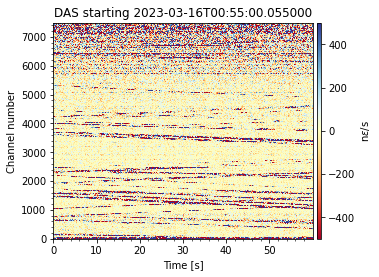

In [15]:
# Make waterfall plot of the event

fig = plt.figure()
ax1 = axes_grid1.host_axes([0.09, 0.10, 0.60, 0.75])

# set color bar axis
vplot = 500  
    
extent = [time_count[0], time_count[-1], channel_list[0], channel_list[-1]]
im1 = ax1.imshow(DAS_data.T, extent=extent, origin='lower',
                 interpolation='none', cmap='RdYlBu', aspect='auto',
                 vmin=-vplot, vmax=vplot);

# Format axes
ax1.set_xlabel("Time [s]")
ax1.xaxis.set_major_locator(AutoLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())

ax1.set_ylabel("Channel number")
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_title("DAS starting " + start_datetime.isoformat())
 

# add color bar
axc = fig.add_axes([0.70, 0.10, 0.01, 0.75])
cb.Colorbar(axc, im1, label='n$\epsilon$/s', orientation='vertical')

plt.show()

In [ ]:
'''
Author: Voon (Aug 23, 2023)
voonhui.lai@anu.edu.au

Function:

1. read QuakeXML file for earthquake information (origin time, distance, magnitude...)

2. download seismic data from AusPass (Australian Seismic Network data server)
basic help: http://auspass.edu.au/help/obspy_request.html 

Network code for SISSLE's seismic node: 2B
currently data is embargoed and password-protected on Auspass. To access, use info below:
user: 2B, password: carrot22 

station names: SIS01, SIS02, SIS03, SIS04, SIS05
Channel: DH[ENZ]
D - corresponds to sample rate 250 Hz (also relates to corner frequency of sensor which is 1 seconds)
H - high gain
ENZ - components

More info: https://www.fdsn.org/networks/detail/2B_2023/ 

3. retrieve seismic traces based on catalog (and picks), rotate horizontal components to along fiber direction 
(and export as numpy.array)



'''
#%%
import matplotlib.pyplot as plt
%matplotlib inline

from obspy import read, Stream, UTCDateTime
import glob
from pathlib import Path

import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#%% 

# Read catalog
import obspy
qml_fileIN = 'sissle_picked_events.qml'

cat = obspy.read_events(qml_fileIN)
print(cat.__str__(print_all=True))

#%% 
# to plot all events

# plot map
HAAST_lat = -43.86078 #estimate locations
HAAST_lon = 169.04276

# Set up a figure
fig = plt.figure(dpi=150)
projection = ccrs.PlateCarree() # Set up a custom projection
ax = fig.add_subplot(111,projection=projection)
ax.set_extent((HAAST_lon-3, HAAST_lon+3, HAAST_lat-3, HAAST_lat+3))

# Draw standard features
ax.gridlines(crs=projection, draw_labels=True)
ax.coastlines()
ax.stock_img()

ax.set_title('%s (sized by color)' %(qml_fileIN))
#HAAST aerodrome
x, y, _ = projection.transform_points(ccrs.Geodetic(), np.array(HAAST_lon), np.array(HAAST_lat)).T
ax.scatter(x, y, 50, color="b", marker="v", edgecolor="k", zorder=3)
plt.text(x*0.999, y*0.990, 'iDAS', va="top", family="monospace", weight="bold")


for event in cat:
    otime=event.origins[0].time
    evlat=event.origins[0].latitude
    evlon=event.origins[0].longitude
    evmag=event.magnitudes[0].mag
    #print(eventid, otime, evmag)
    
    #if evmag >4 or evmag <3:
    #    continue

    x, y, _ = projection.transform_points(ccrs.Geodetic(), np.array(evlon), np.array(evlat)).T
    
    if evmag <= 2: colorIN='yellow'
    if evmag >2 and evmag <=3: colorIN='orange'
    if evmag >3 and evmag <=4: colorIN='red'
    if evmag >4: colorIN='white'
    
    ax.scatter(x, y, evmag*10, color=colorIN, marker="o", edgecolor="k", zorder=3)
#plt.text(x, y, 'EQ', va="top", family="monospace", weight="bold")   

plt.show()


#%% 

# find earthquakes that matches with id

good_eq_id = np.loadtxt('clean_picks_network2B_sissle.txt', dtype='str',skiprows = 2)



#compile all eq ids in catalog:
all_eq_id = []
for eq in cat:
    all_eq_id.append(eq.resource_id.resource_id.split('/')[1])

# find index of earthquakes with clean pick
good_eq_cat_index = []
for item in good_eq_id:
    if all_eq_id.index(item):
        good_eq_cat_index.append(all_eq_id.index(item))

# to plot only the good events

# plot map
HAAST_lat = -43.86078 #estimate locations
HAAST_lon = 169.04276

# Set up a figure
fig = plt.figure(dpi=150)
projection = ccrs.PlateCarree() # Set up a custom projection
ax = fig.add_subplot(111,projection=projection)
ax.set_extent((HAAST_lon-3, HAAST_lon+3, HAAST_lat-3, HAAST_lat+3))

# Draw standard features
ax.gridlines(crs=projection, draw_labels=True)
ax.coastlines()
ax.stock_img()

ax.set_title('Events with clean picks (sized by color)')
#HAAST aerodrome
x, y, _ = projection.transform_points(ccrs.Geodetic(), np.array(HAAST_lon), np.array(HAAST_lat)).T
ax.scatter(x, y, 50, color="b", marker="v", edgecolor="k", zorder=3)
plt.text(x*0.999, y*0.990, 'iDAS', va="top", family="monospace", weight="bold")


for index in good_eq_cat_index:
    event = cat[index]
    otime=event.origins[0].time
    evlat=event.origins[0].latitude
    evlon=event.origins[0].longitude
    evmag=event.magnitudes[0].mag
    #print(eventid, otime, evmag)
    
    #if evmag >4 or evmag <3:
    #    continue

    x, y, _ = projection.transform_points(ccrs.Geodetic(), np.array(evlon), np.array(evlat)).T
    
    if evmag <= 2: colorIN='yellow'
    if evmag >2 and evmag <=3: colorIN='orange'
    if evmag >3 and evmag <=4: colorIN='red'
    if evmag >4: colorIN='white'
    
    ax.scatter(x, y, evmag*10, color=colorIN, marker="o", edgecolor="k", zorder=3)
#plt.text(x, y, 'EQ', va="top", family="monospace", weight="bold")   

plt.show()


# %%


# Connect to AusPass to access seismic data
import obspy
from obspy.clients.fdsn import Client as FDSN_Client
from matplotlib import pyplot as plt
auspass = FDSN_Client('http://auspass.edu.au:8080',user='2B',password='carrot22')

# retrive inventory (metadata for seismic stations)
inv = auspass.get_stations(network="2B",level='response')
#inv.plot() #can quickly plot station locations. might have issues with importing basemap nor cartopy. 



#%% 

# grab events


for index,item in enumerate(good_eq_cat_index):

    if index == 6:   #remove if condition for looping
        eq = cat[item]
        print(eq)
        picks = eq.picks
        origin = eq.origins[0]
        origin_time = origin.time
        origin_latitude = origin.latitude


# %%

# download data

#data parameters
network = "2B"
station = "SIS0*"
location = "*" #n.b. AusPass data typically has a univeral blank (e.g. '') value for ALL station locations. "*" works just as well. 
channel = "DH*" #note that BH* channels here are 10 Hz, HH* are 100 
time0 = origin_time 
time1 = time0 + 120 #180 seconds after time0

# download waveforms
st = auspass.get_waveforms(network=network,station=station,location=location,channel=channel,starttime=time0,endtime=time1)

# remove instrument response (count to velocity in m/s, correct for any phase shift)
st.remove_response(inventory=inv, output="VEL",pre_filt=[0.01,.05,100,125],water_level=20) #this automatically parses the inventory for the correct network/station/channel response!
st.plot(); plt.show()

#
# %% 

#other useful functions

#example: apply bandpass filter using in-built obspy function
# see below to filter numpy array directly
st_copy = st.copy() #duplicate stream object
st_copy.filter('bandpass',freqmin=1.0, freqmax=4.0)

st_copy.plot()

#example: decimate
st_copy = st.copy()
st_copy.decimate(2, strict_length=False, no_filter=True)
print('Original sampling rate %i Hz; new sampling rate %i Hz' %(st[0].stats.sampling_rate,st_copy[0].stats.sampling_rate))

# %%

# to rotate data
from obspy.signal.rotate import rotate_ne_rt
st_copy = st.copy()

#specify backazimuth
#i.e., the angle measured between the vector pointing from the station to the source 
# here specify as angle of fiber (pointing southward)
# import pyproj
# geodesic = pyproj.Geod(ellps='WGS84')
# lat1 = -43.901053; long1 = 169.059966  #ch1396 south line
# lat2 = -43.915692; long2 = 169.075805  #ch1925 south line
# fwd_azimuth,back_azimuth,distance_in_m = geodesic.inv(long1, lat1, long2, lat2)
# print(fwd_azimuth,back_azimuth,distance_in_m)
# 141.97176998096722 -38.03921447832727 2065.066340304079

baz =  141.97176998096722 

# using SIS02 as example
#print('use network %s station %s channel %s and %s' %(st_copy[3].stats.network,st_copy[3].stats.station,st_copy[3].stats.channel,st_copy[4].stats.channel))
#tr_north = st_copy[3]
#tr_east = st_copy[4]
#stationIN = st_copy[3].stats.station

# using SIS03 as example
print('use network %s station %s channel %s and %s' %(st_copy[7].stats.network,st_copy[7].stats.station,st_copy[7].stats.channel,st_copy[8].stats.channel))
tr_north = st_copy[7]
tr_east = st_copy[8]
stationIN = st_copy[7].stats.station

# output = rotated time series in numpy array. 
print('rotate data')
tr_radial, tr_tangential = rotate_ne_rt(tr_north.data,tr_east.data,baz)

#%%
# 

# find sampling frequency, create time list
print('generate time list')
import datetime
npts = tr_north.stats.npts
samprate = tr_north.stats.sampling_rate
dt = 1/samprate
timelist_in_sec = np.arange(0, npts * dt, dt)
timelist_in_UTCdatetime = np.array([time0 + datetime.timedelta(seconds=i*dt) for i in range(0,npts)])
timelist_in_ISOformat = np.array([timelist_in_UTCdatetime[i].isoformat() for i in range(0,len(timelist_in_UTCdatetime))])
 

# find P and S wave arrival time 

print('find P and S wave arrival time for station %s' %(stationIN))
relevant_picks = [p for p in eq.picks if p.waveform_id.station_code == stationIN]
for pick in relevant_picks:
    if pick.phase_hint == 'P':
        P_arrival_UTC = pick.time
    elif pick.phase_hint == 'S':
        S_arrival_UTC = pick.time


#
print('find origin time, P and S arrival times in seconds corresponding to beginning of trace ')
Origin_time_in_seconds =  origin_time - timelist_in_UTCdatetime[0]
P_arrival_in_seconds =  P_arrival_UTC - timelist_in_UTCdatetime[0]
S_arrival_in_seconds =  S_arrival_UTC - timelist_in_UTCdatetime[0]


#%% 
# to filter numpy array directly
from scipy.signal import tukey, butter, filtfilt, detrend, convolve

def v_filter(data, fs, f1, f2, alpha=0.05):
    '''
    :param data: shape: nch * npts
    :param fs: sampling frequency
    :param f1: low frequency
    :param f2: high frequency
    :param alpha: taper length
    :return: filtered data
    '''
    window = tukey(data.shape[0], alpha=alpha)
    passband = [f1*2/fs, f2*2/fs]
    b, a = butter(4, passband, 'bandpass')

    dataf = filtfilt(b,a,data * window)
    return dataf

freqmin = 0.5; freqmax = 5
print('another way to filter numpy array directly')
tr_radial_filtered = v_filter(tr_radial, samprate, freqmin, freqmax, alpha=0.05)

# %%

# Plotting using matplotlib

# assign output filename

fig = plt.figure(dpi=350)
fig.set_figwidth(7); fig.set_figheight(6)

ax1 = fig.add_subplot(211)
trace = st[0]
labelIN = 'radial'
ax1.plot(timelist_in_sec, tr_radial, 'k',label=labelIN)
ax1.set_ylabel('Velocity')
ax1.legend(handlelength=0, handletextpad=0, fancybox=True, loc = 'upper right')

ax1.axvline(x=Origin_time_in_seconds,linestyle='--')
ax1.axvline(x=P_arrival_in_seconds,linestyle='--')
ax1.axvline(x=S_arrival_in_seconds,linestyle='--')

ax2 = fig.add_subplot(212)
trace = st[0]
labelIN = 'tangential'
ax2.plot(timelist_in_sec, tr_tangential, 'k',label=labelIN)
ax2.set_ylabel('Velocity')
ax2.legend(handlelength=0, handletextpad=0, fancybox=True, loc = 'upper right')

ax2.axvline(x=Origin_time_in_seconds,linestyle='--')
ax2.axvline(x=P_arrival_in_seconds,linestyle='--')
ax2.axvline(x=S_arrival_in_seconds,linestyle='--')

#share axis
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)

ax1.set_title(stationIN)
ax2.set_xlabel('Time [s]')


#plt.savefig('./plot.png',format='png',bbox_inches='tight')

plt.show()
plt.close()
# %%

# to save traces
np.save(stationIN+'_north_vel.npy', tr_north.data)
np.save(stationIN+'_east_vel.npy', tr_east.data)
np.save(stationIN+'_radial_vel.npy', tr_radial)
np.save(stationIN+'_tangential_vel.npy', tr_tangential)